# 3D Convolutional Neural Network for Tomographic Alignment

## Expanding the Network: ResNet and Cross Correlating New Projections

Since based on previous analysis it is likely that the network was too small to properly identify the features necessary for alignment, the next logical step is to expand the network. Making deeper neural networks usually results in diminishing returns, but residual neural networks have proven to successfully allow for deeper neural networks. Now this model structure will be used in order to find some form of convergence.

While it seems like the ResNet will increase the performance of the model on larger training sets, testing convergence is still a major problem. Now the input data will be modified to find the correlation between the original projection and its corresponding reprojection. This will hopefully allow for better understanding of the specific alignment problem by the neural network.

In [5]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf
from scipy.fft import fft2, fftshift
from scipy.signal import correlate

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [6]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))
!pwd

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True
/home/liam/Projects/Tomographic Alignment


In [7]:
def crosscorr_reprojection(data, entries):
    
    ang = tomopy.angles(data[0][0][0, 0].shape[0])
    _rec = 1e-12 * np.ones((data[0][0][0, 0].shape[1], data[0][0][0, 0].shape[2], data[0][0][0, 0].shape[2]))
    data_copy = data.copy()
    out_data = np.zeros((entries, 2), dtype = object)
    
    for i in range (entries):
    
        out_data[i, 0] = np.zeros((1, 1, data[0][0][0, 0].shape[0], data[0][0][0, 0].shape[1] * 2 - 1,
                                      data[0][0][0, 0].shape[2] * 2 - 1))
        out_data[i, 1] = data_copy[i, 1]
        
        rec = tomopy.recon(data_copy[i][0][0, 0], ang, center = None, 
                            algorithm = 'gridrec', init_recon = _rec)
        reproj = tomopy.project(rec, ang, center = None, pad = False)
        
        for j in range (data[0][0][0, 0].shape[0]):
            
            out_data[i, 0][0, 0, j] = correlate(data_copy[i][0][0, 0, j], reproj[j], method = 'fft')
        
    return out_data

In [8]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 25
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data)
data = crosscorr_reprojection(data, entries)

In [9]:
# Checking shape of training and testing splits
trainset, testset = np.split(data, [int(entries * 4 / 5)])
print("Shape of Training Dataset: {}".format(trainset.shape))
print("Shape of Testing Dataset: {}".format(testset.shape))

Shape of Training Dataset: (20, 2)
Shape of Testing Dataset: (5, 2)


In [10]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

# Get inplanes for resnet
def get_inplanes():
    return [64, 128, 256, 512]


# Preset for a 3x3x3 kernel convolution
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


# Preset for a 1x1x1 kernel convolution
def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

# Basic block for resnet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
# Bottleneck block for resnet
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    

# Resnet structure
class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=360):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    # make layer helper function
    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Generates form of resnet
def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [11]:
model = generate_model(50)
summary(model, (1, 1, 180, 255, 367))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 360]                  --
├─Conv3d: 1-1                            [1, 64, 180, 128, 184]    21,952
├─BatchNorm3d: 1-2                       [1, 64, 180, 128, 184]    128
├─ReLU: 1-3                              [1, 64, 180, 128, 184]    --
├─MaxPool3d: 1-4                         [1, 64, 90, 64, 92]       --
├─Sequential: 1-5                        [1, 256, 90, 64, 92]      --
│    └─Bottleneck: 2-1                   [1, 256, 90, 64, 92]      --
│    │    └─Conv3d: 3-1                  [1, 64, 90, 64, 92]       4,096
│    │    └─BatchNorm3d: 3-2             [1, 64, 90, 64, 92]       128
│    │    └─ReLU: 3-3                    [1, 64, 90, 64, 92]       --
│    │    └─Conv3d: 3-4                  [1, 64, 90, 64, 92]       110,592
│    │    └─BatchNorm3d: 3-5             [1, 64, 90, 64, 92]       128
│    │    └─ReLU: 3-6                    [1, 64, 90, 64, 92]       --


In [12]:
torch.cuda.empty_cache()
print("Cleared Cache.")

Cleared Cache.


In [13]:
# Train the model

# Create writer and profiler to analyze loss over each epoch
# writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = generate_model(50)
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 2e-1, momentum=0.9, weight_decay = 0)
criterion = nn.MSELoss(reduction = 'mean')
criterion.to(device)
num_epochs = 500

# Iniitializing variables to show statistics
iteration = 0
test_iteration = 0
loss_list = []
test_loss_list = []
epoch_loss_averages = []
test_epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    
    epoch_loss = 0
    test_epoch_loss = 0
    
    for i, data in enumerate(trainset, 0):
        
        inputs, truths = norm(torch.from_numpy(data[0]).to(device).float()), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        # writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Epoch: {}   Training Loss: {} '.format(epoch, epoch_loss / trainset.shape[0]))
            
    for i, test_data in enumerate(testset, 0):
        
        inputs, truths = norm(torch.from_numpy(test_data[0]).to(device).float()), torch.from_numpy(test_data[1]).to(device).float()
        outputs = net(inputs).to(device)
        test_loss = criterion(outputs, truths)
        
        # writer.add_scalar("Loss / Test", test_loss, epoch) # adds testing loss scalar
        test_loss_list.append(test_loss.cpu().detach().numpy())
        test_epoch_loss += test_loss.cpu().detach().numpy()
        
        test_iteration +=1
        if test_iteration % testset.shape[0] == 0:
            test_epoch_loss_averages.append(test_epoch_loss / testset.shape[0])
            print('Epoch: {}   Validation Loss: {} '.format(epoch, test_epoch_loss / testset.shape[0]))
            
# writer.flush()
# writer.close()

Device: cuda:0
Epoch: 0   Training Loss: 10.51127290725708 
Epoch: 0   Validation Loss: 8.211798000335694 
Epoch: 1   Training Loss: 8.453088641166687 
Epoch: 1   Validation Loss: 8.308775711059571 
Epoch: 2   Training Loss: 8.432201027870178 
Epoch: 2   Validation Loss: 8.179448986053467 
Epoch: 3   Training Loss: 8.352555060386658 
Epoch: 3   Validation Loss: 8.196695041656493 
Epoch: 4   Training Loss: 8.310686278343201 
Epoch: 4   Validation Loss: 8.210187721252442 
Epoch: 5   Training Loss: 8.299925208091736 
Epoch: 5   Validation Loss: 8.217224884033204 
Epoch: 6   Training Loss: 8.294310069084167 
Epoch: 6   Validation Loss: 8.220510387420655 
Epoch: 7   Training Loss: 8.290028762817382 
Epoch: 7   Validation Loss: 8.22336549758911 
Epoch: 8   Training Loss: 8.2864670753479 
Epoch: 8   Validation Loss: 8.225584793090821 
Epoch: 9   Training Loss: 8.283440375328064 
Epoch: 9   Validation Loss: 8.227668380737304 
Epoch: 10   Training Loss: 8.280844807624817 
Epoch: 10   Validation

Epoch: 88   Training Loss: 8.236530447006226 
Epoch: 88   Validation Loss: 8.220237922668456 
Epoch: 89   Training Loss: 8.253018045425415 
Epoch: 89   Validation Loss: 8.229107761383057 
Epoch: 90   Training Loss: 8.25300681591034 
Epoch: 90   Validation Loss: 8.234869575500488 
Epoch: 91   Training Loss: 8.251488208770752 
Epoch: 91   Validation Loss: 8.234356117248534 
Epoch: 92   Training Loss: 8.250774145126343 
Epoch: 92   Validation Loss: 8.23685073852539 
Epoch: 93   Training Loss: 8.250380158424377 
Epoch: 93   Validation Loss: 8.237520027160645 
Epoch: 94   Training Loss: 8.249931931495667 
Epoch: 94   Validation Loss: 8.237491989135743 
Epoch: 95   Training Loss: 8.249436950683593 
Epoch: 95   Validation Loss: 8.237232494354249 
Epoch: 96   Training Loss: 8.248859119415282 
Epoch: 96   Validation Loss: 8.236751747131347 
Epoch: 97   Training Loss: 8.248139357566833 
Epoch: 97   Validation Loss: 8.235834980010987 
Epoch: 98   Training Loss: 8.247162652015685 
Epoch: 98   Vali

Epoch: 174   Training Loss: 8.03883125782013 
Epoch: 174   Validation Loss: 8.225817108154297 
Epoch: 175   Training Loss: 8.276056432724 
Epoch: 175   Validation Loss: 8.212131977081299 
Epoch: 176   Training Loss: 8.20826563835144 
Epoch: 176   Validation Loss: 8.196905612945557 
Epoch: 177   Training Loss: 8.153603267669677 
Epoch: 177   Validation Loss: 8.215267658233643 
Epoch: 178   Training Loss: 8.158793830871582 
Epoch: 178   Validation Loss: 8.257176399230957 
Epoch: 179   Training Loss: 8.33467493057251 
Epoch: 179   Validation Loss: 8.18413496017456 
Epoch: 180   Training Loss: 8.242982196807862 
Epoch: 180   Validation Loss: 8.190584182739258 
Epoch: 181   Training Loss: 8.16393048763275 
Epoch: 181   Validation Loss: 8.258791065216064 
Epoch: 182   Training Loss: 8.094980621337891 
Epoch: 182   Validation Loss: 8.226588153839112 
Epoch: 183   Training Loss: 8.002995729446411 
Epoch: 183   Validation Loss: 8.336601734161377 
Epoch: 184   Training Loss: 8.002598524093628 
E

Epoch: 259   Validation Loss: 10.995864582061767 
Epoch: 260   Training Loss: 4.496759402751922 
Epoch: 260   Validation Loss: 11.38410997390747 
Epoch: 261   Training Loss: 4.49657139480114 
Epoch: 261   Validation Loss: 11.731262969970704 
Epoch: 262   Training Loss: 4.433688712120056 
Epoch: 262   Validation Loss: 11.9615047454834 
Epoch: 263   Training Loss: 4.387972146272659 
Epoch: 263   Validation Loss: 11.61041316986084 
Epoch: 264   Training Loss: 4.5638676807284355 
Epoch: 264   Validation Loss: 10.967678833007813 
Epoch: 265   Training Loss: 4.345306879281997 
Epoch: 265   Validation Loss: 12.04358434677124 
Epoch: 266   Training Loss: 4.135177850723267 
Epoch: 266   Validation Loss: 11.297475337982178 
Epoch: 267   Training Loss: 4.120035149157047 
Epoch: 267   Validation Loss: 11.713478565216064 
Epoch: 268   Training Loss: 4.466030091047287 
Epoch: 268   Validation Loss: 11.35551414489746 
Epoch: 269   Training Loss: 4.03730719089508 
Epoch: 269   Validation Loss: 12.1436

Epoch: 344   Validation Loss: 11.38465690612793 
Epoch: 345   Training Loss: 2.93125624358654 
Epoch: 345   Validation Loss: 12.072968292236329 
Epoch: 346   Training Loss: 2.8255141019821166 
Epoch: 346   Validation Loss: 12.311524963378906 
Epoch: 347   Training Loss: 2.4638200506567953 
Epoch: 347   Validation Loss: 12.243471336364745 
Epoch: 348   Training Loss: 2.11022210419178 
Epoch: 348   Validation Loss: 11.86124095916748 
Epoch: 349   Training Loss: 1.8734673522412777 
Epoch: 349   Validation Loss: 12.07948112487793 
Epoch: 350   Training Loss: 1.9528737641870975 
Epoch: 350   Validation Loss: 12.57254581451416 
Epoch: 351   Training Loss: 1.700848814845085 
Epoch: 351   Validation Loss: 12.165214538574219 
Epoch: 352   Training Loss: 1.530407078564167 
Epoch: 352   Validation Loss: 12.5172119140625 
Epoch: 353   Training Loss: 1.6667930580675603 
Epoch: 353   Validation Loss: 12.092961883544922 
Epoch: 354   Training Loss: 1.528360515832901 
Epoch: 354   Validation Loss: 12.

Epoch: 427   Validation Loss: 12.23602523803711 
Epoch: 428   Training Loss: 0.00013430653907562374 
Epoch: 428   Validation Loss: 12.250159645080567 
Epoch: 429   Training Loss: 0.00012771156407325178 
Epoch: 429   Validation Loss: 12.256972885131836 
Epoch: 430   Training Loss: 8.656839963805396e-05 
Epoch: 430   Validation Loss: 12.243012428283691 
Epoch: 431   Training Loss: 7.619783455083961e-05 
Epoch: 431   Validation Loss: 12.24257526397705 
Epoch: 432   Training Loss: 5.9286380383127836e-05 
Epoch: 432   Validation Loss: 12.253199577331543 
Epoch: 433   Training Loss: 4.200328717161028e-05 
Epoch: 433   Validation Loss: 12.2493106842041 
Epoch: 434   Training Loss: 4.01248898697304e-05 
Epoch: 434   Validation Loss: 12.24284324645996 
Epoch: 435   Training Loss: 2.2457000409303873e-05 
Epoch: 435   Validation Loss: 12.248013496398926 
Epoch: 436   Training Loss: 2.649517977033611e-05 
Epoch: 436   Validation Loss: 12.251019859313965 
Epoch: 437   Training Loss: 1.3055643728421

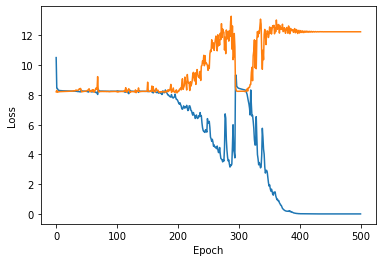

In [14]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.plot(test_epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

This method showed training convergence and as expected did not show testing convergence. However, this is understandable given how small the training dataset is.